# London Bike-Share Usage Analysis
#### Bicycle journeys from Transport for London (TfL) for August 2023

This dataset is obtained from kaggle and contains detailed records of 776,527 bicycle journeys from the Transport for London (TfL) Cycle Hire system spanning from August 1 to August 31, 2023. The TfL Cycle Hire initiative provides publicly accessible bicycles for rent across London, promoting sustainable transportation and physical fitness. This comprehensive dataset captures individual trip data, and provides a snapshot of cycling activity during the month, including start and end details for each journey, the bicycle used, and the duration of hire.


Source
This dataset was sourced directly from the Transport for London's official website, which provides open data to encourage public use and analysis. More details and related datasets can be found at Transport for London (TfL).

Reference:
Transport for London. (August 2023). TfL Cycle Hire Trip Data. Retrieved [Date Retrieved], from https://tfl.gov.uk/info-for/open-data-users/our-open-data.

### Research Objectives

- Identify the top five most frequented start and end stations based on trip counts.
(Purpose: To determine key nodes in the bike-sharing network and assess spatial demand concentration.)
- Determine the most common origin-destination station pairs for trips conducted in August 2023.
(Purpose: To uncover dominant travel corridors and potential commuting patterns.)
- Analyze hourly trip distributions to identify peak demand periods across the day.
(Purpose: To inform operational planning and resource allocation during high-usage windows.)
- Calculate and compare the average trip durations for round trips versus one-way trips.
(Purpose: To explore behavioral differences in trip types and their implications for system usage.)
- Assess whether bike trip demand is significantly higher on weekdays compared to weekends.
(Purpose: To evaluate temporal usage trends and support scheduling or promotional strategies.)
- Identify the specific days in August 2023 with the highest average trip durations.
(Purpose: To detect anomalies or patterns in user behavior that may be linked to events or conditions.)
- Disaggregate peak hour demand by day to reveal daily temporal usage patterns.
(Purpose: To provide granular insights into how demand fluctuates across individual days.)
- Apply appropriate statistical methods to validate observed patterns and test hypotheses.
(Purpose: To ensure analytical rigor and support evidence-based conclusions.)


## Importing Libraries

In [1]:
# IMPORTING LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns 
from scipy.stats import mannwhitneyu
from scipy.stats import normaltest
from scipy import stats
import scikit_posthocs as sp
from scipy.stats import chi2_contingency




## Data cleaning and Manipulation

In [ ]:
# READING THE DATASET
BikeSharing = pd.read_csv(r"C:\Users\DELL\Documents\TECHCRUSH\DATA ANALYTICS\CAPSTONE PROJECT\Sample Datasets\London Bike-Share Usage Dataset\LondonBikeJourneyAug2023.csv")

# CLEANING THE DATASET
# removing duplicates
BikeSharing= BikeSharing.drop_duplicates()

# CHANGING THE DATA TYPE
# changing the date columns to datetime
BikeSharing[['start_date',
             'end_date']] = BikeSharing[['start_date',
                                          'end_date']].apply(pd.to_datetime)
# converting the following numeric columns to categorical
BikeSharing[['number',
             'start_station_number',
             'end_station_number',
             'bike_number']] = BikeSharing[['number',
                                            'start_station_number', 
                                            'end_station_number',
                                            'bike_number']].astype('category')

# REMOVING OUTLIERS
BikeSharing = BikeSharing[BikeSharing['total_duration_ms'] <= 3600000]

# REMOVING WHITESPACES
BikeSharing['start_station'].str.strip()
BikeSharing['end_station'].str.strip()

# CREATING NEW COLUMNS (FEATURE ENGINEERING)
# creating Total duration in minutes column
BikeSharing['total_duration_min'] = BikeSharing['total_duration_ms'] / (1000*60)
# creating trip type column
BikeSharing['trip_type'] = np.where(BikeSharing['start_station'] == BikeSharing['end_station'], 'Round trip', 'One way trip')
# creating hour of trip start column
BikeSharing['start_hour'] = BikeSharing['start_date'].dt.hour
# creating day of trip start column
BikeSharing['day_of_start_date'] = BikeSharing['start_date'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
BikeSharing['day_of_start_date'] = pd.Categorical(BikeSharing['day_of_start_date'], ordered=True, categories=weekday_order)
# creating week type column
BikeSharing['week_type'] = BikeSharing['day_of_start_date'].apply(lambda x: 'Weekday' if x in ['Monday',
                                                                                               'Tuesday',
                                                                                               'Wednesday',
                                                                                               'Thursday',
                                                                                               'Friday'] else 'Weekend') 
#changing the start_hour column to category
BikeSharing['start_hour'] = BikeSharing['start_hour'].astype('category')
# creating station pairs column
BikeSharing['station_pairs'] = BikeSharing['start_station'] + ' >>> ' + BikeSharing['end_station']
# creating total duration in time column
BikeSharing['total_duration_time']  = pd.to_timedelta(BikeSharing['total_duration_ms'], unit='ms')


## Exploratory Data Analysis

In [6]:
# TOP 5 START AND END STATIONS
top5startstations= BikeSharing['start_station'].value_counts().head().index
top5endstations = BikeSharing['end_station'].value_counts().head().index

# COUNTING THE NUMBER OF TRIPS PER DAY
peakday = BikeSharing['day_of_start_date'].value_counts().index

# COUNTING THE NUMBER OF TRIPS PER TRIP TYPE
BikeSharing['trip_type'].value_counts().head()

# COUNTING THE NUMBER OF TRIPS PER BIKE
bikeID = BikeSharing['bike_number'].value_counts().head(5).index

In [7]:
# COUNTING THE NUMBER OF TRIPS PER STATION PAIR
# creating a subset for one way trips
One_way_trip = BikeSharing[BikeSharing['trip_type'] == 'One way trip']
# counting the number of trips per station pair
top_station_pairs = One_way_trip['station_pairs'].value_counts().head()
top_station_pairs

station_pairs
Hyde Park Corner, Hyde Park >>> Albert Gate, Hyde Park                 392
Albert Gate, Hyde Park >>> Hyde Park Corner, Hyde Park                 379
Ackroyd Drive, Bow >>> Maplin Street, Mile End                         322
Black Lion Gate, Kensington Gardens >>> Hyde Park Corner, Hyde Park    303
Hyde Park Corner, Hyde Park >>> Triangle Car Park, Hyde Park           294
Name: count, dtype: int64

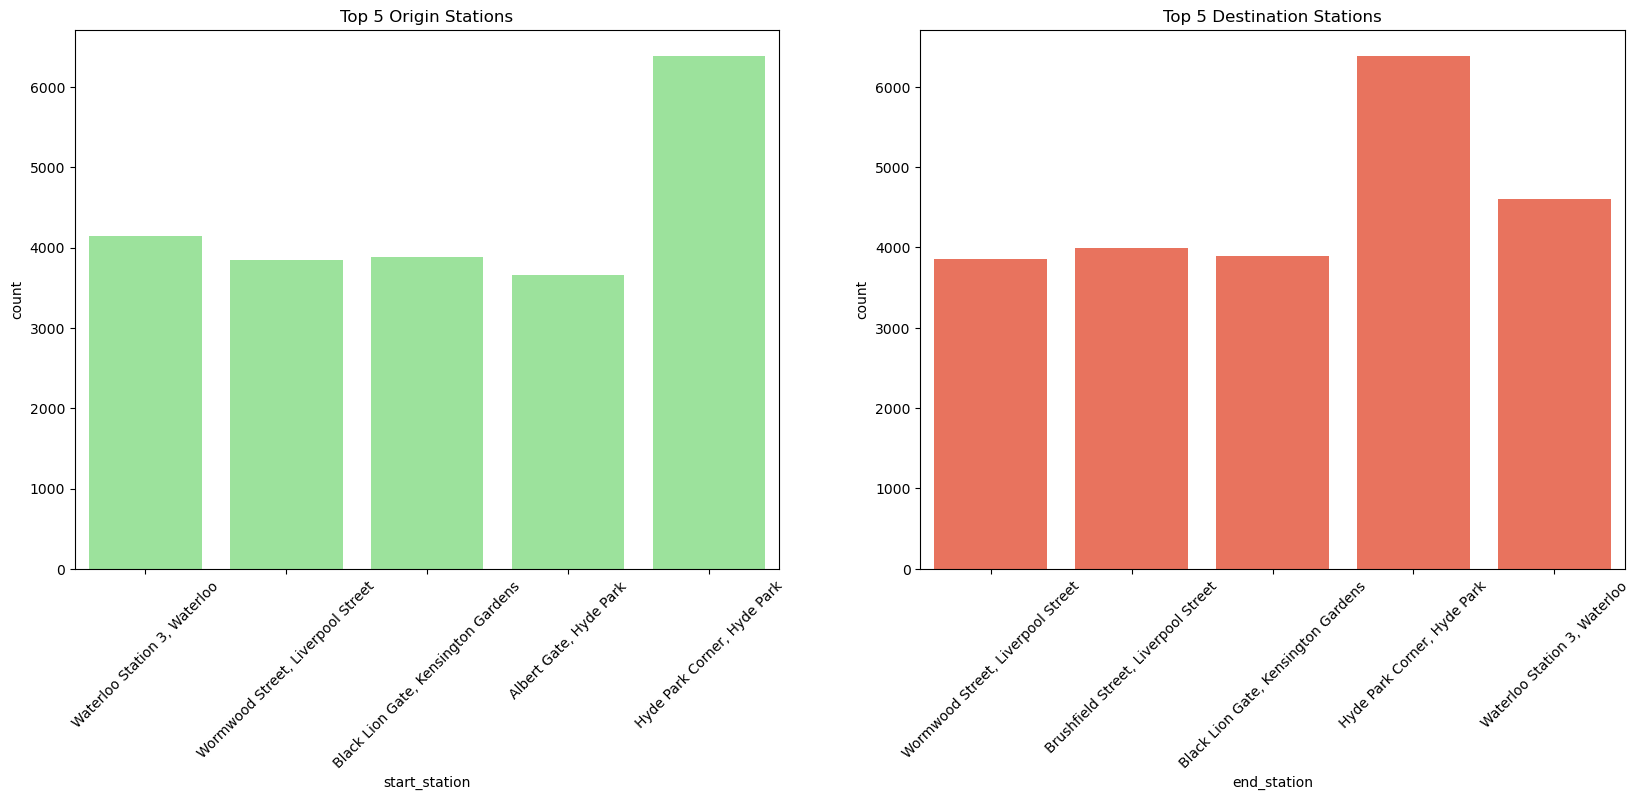

In [8]:
# PLOTTING THE TOP 5 START AND END STATIONS
# creating a figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(20, 7))
# plotting the top 5 start and end stations
sns.countplot(x='start_station', \
               color = 'lightgreen', \
                 data= BikeSharing[BikeSharing['start_station'].isin(top5startstations)], ax=axes[0])
axes[0].set_title('Top 5 Origin Stations')

sns.countplot(x='end_station', color = 'tomato', \
              data= BikeSharing[BikeSharing['end_station'].isin(top5endstations)], ax=axes[1])
axes[1].set_title('Top 5 Destination Stations')
# rotating the xtick labels
for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.savefig("Start_end_station.png", dpi=500, bbox_inches='tight')



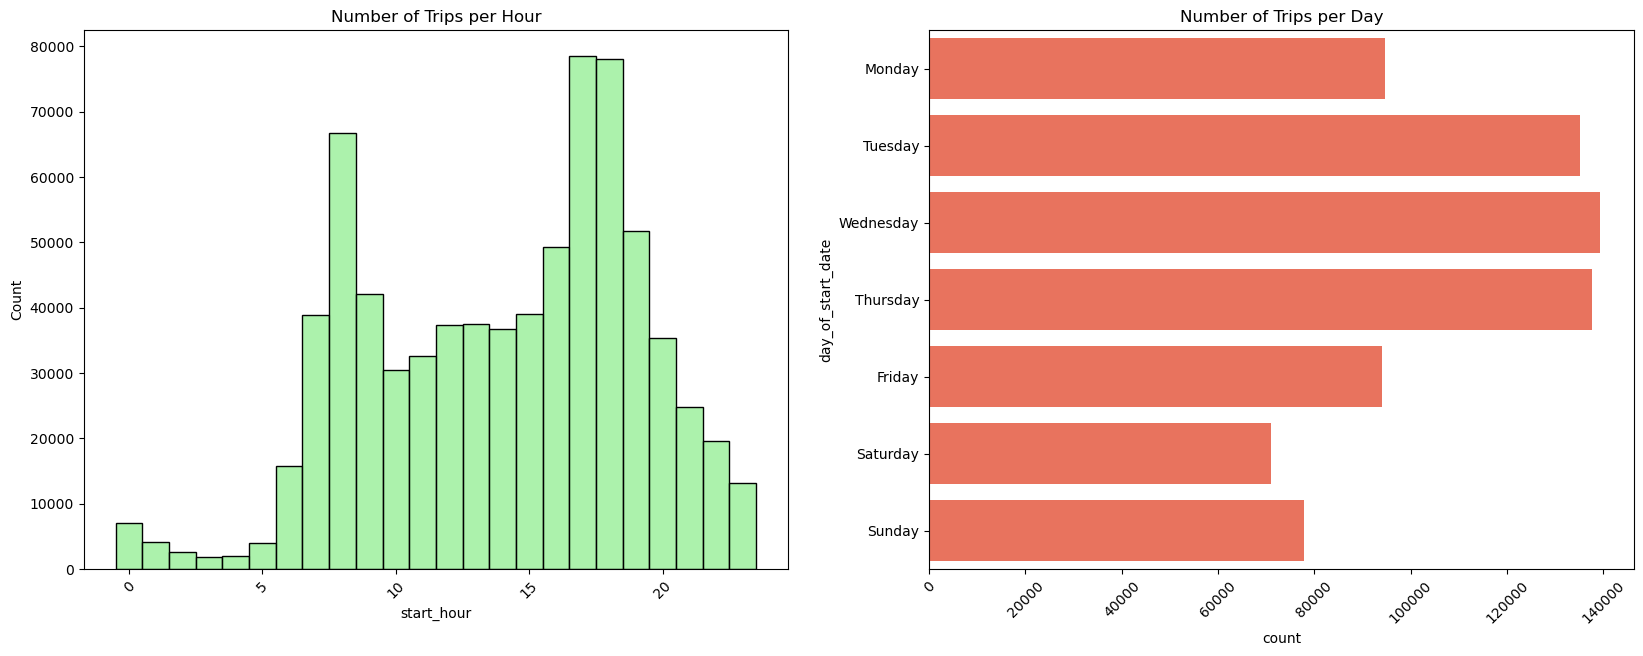

In [9]:
# PLOTTING THE NUMBER OF TRIPS PER DAY AND PEAK HOUR OF TRIPS
# creating a figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(20, 7))
# plotting the number of trips per day and peak hour
sns.histplot(x='start_hour', color = 'lightgreen', data= BikeSharing, ax=axes[0])
axes[0].set_title('Number of Trips per Hour')
sns.countplot(y='day_of_start_date', color = 'tomato', data= BikeSharing[BikeSharing['day_of_start_date'].isin(peakday)], ax=axes[1])
axes[1].set_title('Number of Trips per Day')
# rotating the xtick labels
for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.savefig("Start_hour.png", dpi=500, bbox_inches='tight')

In [10]:
# FINDING THE AVERAGE DURATION OF EACH TRIP TYPE
Average_Trips = BikeSharing.groupby('trip_type')['total_duration_time'].mean()
Average_Trips

trip_type
One way trip   0 days 00:16:00.567081700
Round trip     0 days 00:23:53.989982949
Name: total_duration_time, dtype: timedelta64[ns]

In [11]:
Median_Trips = BikeSharing.groupby('trip_type')['total_duration_time'].median()
Median_Trips

trip_type
One way trip   0 days 00:13:17.773000
Round trip     0 days 00:24:35.793000
Name: total_duration_time, dtype: timedelta64[ns]

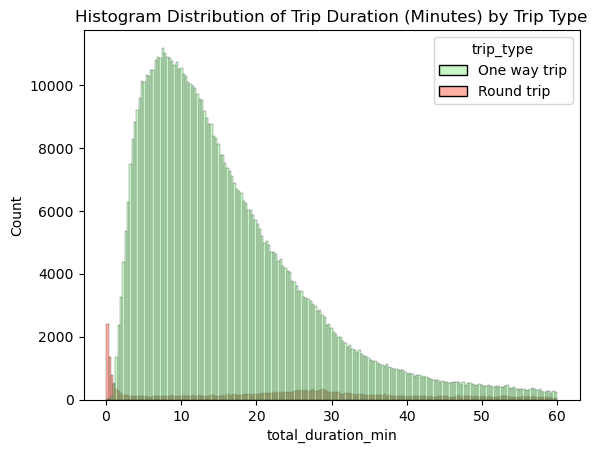

In [12]:
# PLOTTING A HISTOGRAM TO COMPARE THE DURATION OF EACH TRIP TYPE
# setting up the hue color map
hue_color = {'One way trip' : 'lightgreen',\
             'Round trip' : 'tomato'}
sns.histplot(x='total_duration_min', data = BikeSharing, hue='trip_type', palette=hue_color)
plt.title('Histogram Distribution of Trip Duration (Minutes) by Trip Type')
plt.savefig("Histogram.png", dpi=500, bbox_inches='tight')

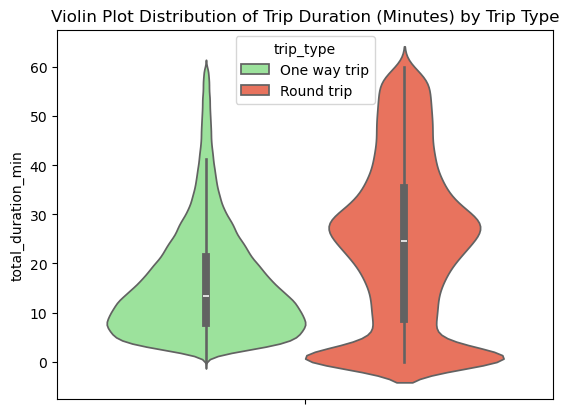

In [13]:
# PLOTTING A VIOLIN PLOT TO COMPARE THE DURATION OF EACH TRIP TYPE
sns.violinplot(data=BikeSharing, y= 'total_duration_min', hue = 'trip_type', 
               palette={"One way trip": "lightgreen", "Round trip": "tomato"})

plt.title('Violin Plot Distribution of Trip Duration (Minutes) by Trip Type')

plt.savefig("Violin.png", dpi=500, bbox_inches='tight')

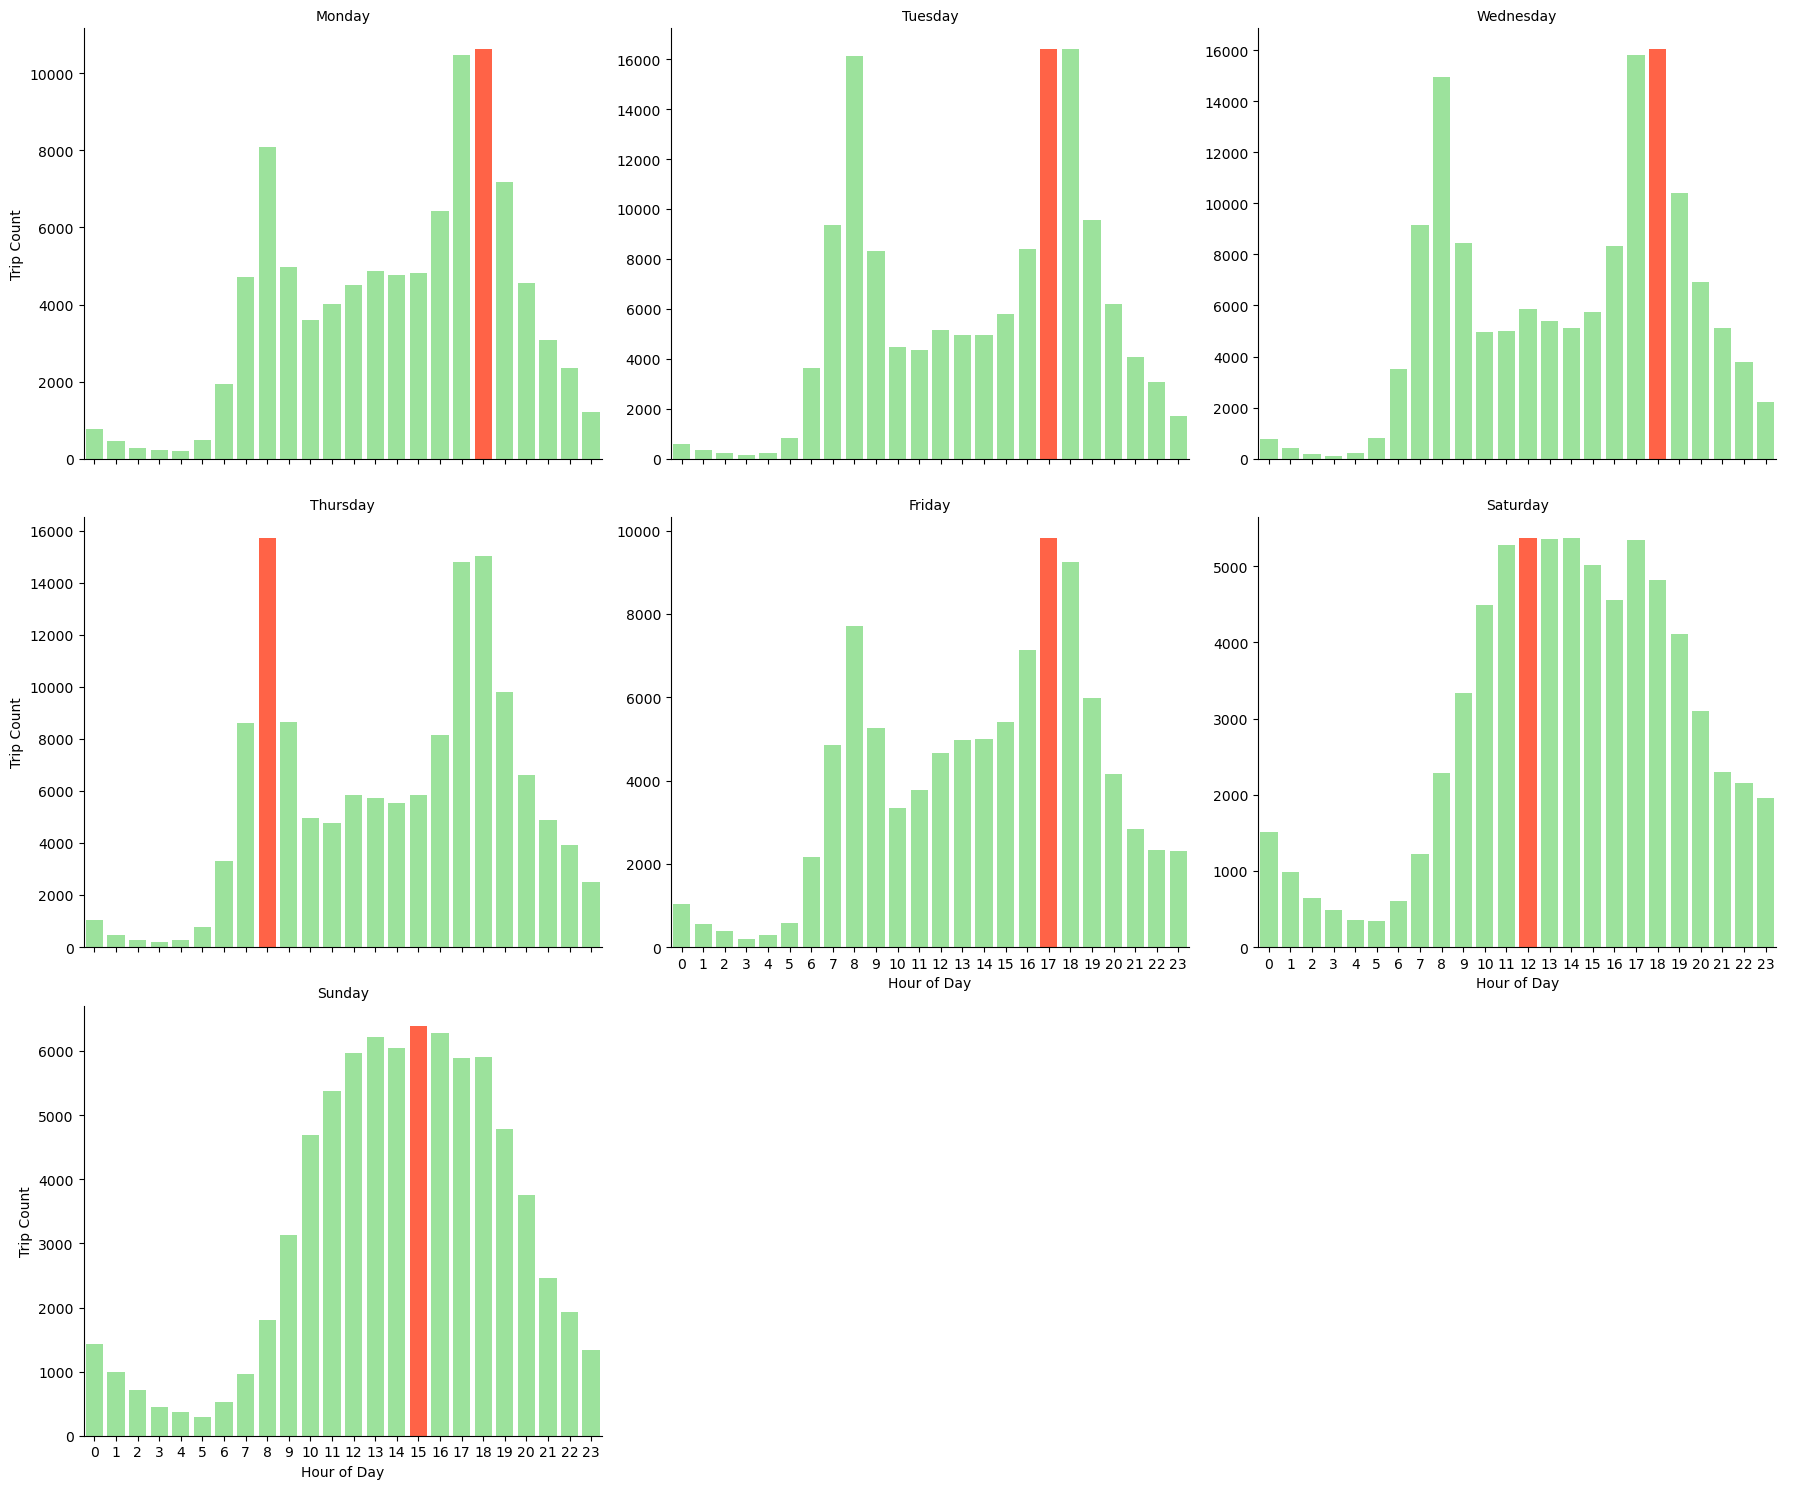

In [16]:
# PLOTTING A BAR PLOT OF THE PEAK HOUR OF DEMAND PER DAY

# creating a subset by grouping by day and hour
hourly_counts = (
    BikeSharing.groupby(['day_of_start_date', 'start_hour'], observed=False).size().reset_index(name='count'))
# ordering the days
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_counts['day_of_start_date'] = pd.Categorical(
    hourly_counts['day_of_start_date'], ordered=True, categories=weekday_order
)
# creating the bar plot
g = sns.catplot(
    data=hourly_counts, x='start_hour', y='count',
    kind='bar', col='day_of_start_date', col_wrap=3, sharey=False,
    height=5, aspect=1.2, color='lightgreen'
)
# changing the color of the peak hour
for ax in g.axes.flat: # iterating over the axes
    bars=ax.patches # getting the bars
    if bars: 
        peak_bar = max(bars, key=lambda bar: bar.get_height())  # getting the bar with the highest height.
        peak_bar.set_facecolor('tomato')    # setting the facecolor of the highest bar to tomato.

# setting the title and labels
g.set_titles("{col_name}")
g.set_axis_labels("Hour of Day", "Trip Count")

plt.savefig("Peak_hour.png", dpi=500, bbox_inches='tight')



## Inferential Statistics (Hypothesis Testing)

  We will perform the D’Agostino and Pearson normality test to statistically corfirm that Total duration per minuties of the data is not normally distributed.

In [18]:
# PERFORMING THE D’Agostino and Pearson normality test
stat, p = normaltest(BikeSharing['total_duration_min'])
print(f"D’Agostino and Pearson p-value: {p:.4f}")

D’Agostino and Pearson p-value: 0.0000


In [19]:
# PERFORMING THE Mann-Whitney U test
# creating a subset for round trip and one way trip duration
Round_trip_duration = BikeSharing[BikeSharing['trip_type'] == 'Round trip']['total_duration_min']
One_way_trip_duration = BikeSharing[BikeSharing['trip_type'] == 'One way trip']['total_duration_min']
# performing the Mann-Whitney U test
U_stats, p = mannwhitneyu(Round_trip_duration, One_way_trip_duration, alternative='greater')
print(f'U-statistic: {U_stats:.3f}, p-value: {p:.3f}')



U-statistic: 15025400453.000, p-value: 0.000


With a U-statistic: 15025400453.000, p-value: 0.000, We reject the null hypothesis. This therefore indicates that round trips statistically take a longer duration compared to One way trips.

In [21]:
# PERFORMING THE Chi-square test
# creating a crosstab
crosstab = pd.crosstab(BikeSharing['trip_type'], BikeSharing['week_type'])
print(crosstab)
# performing the Chi-square test
chi2, p, dof, expected = chi2_contingency(crosstab)
print(f'Chi-square : {chi2:.3f}, p-value: {p:.3f}, Degrees of freedom: {dof}')

week_type     Weekday  Weekend
trip_type                     
One way trip   576628   139773
Round trip      24272     8983
Chi-square : 1124.022, p-value: 0.000, Degrees of freedom: 1


Chi-square : 1124.022, p-value: 0.000. This clearly indicates that Trip type clearly differs by week type. In other words, people change their travel behavior significantly depending on whether it's a weekday or weekend.


In [22]:
# PERFORMING THE Kruskal-Wallis test to compare the peak hour demand per day
# creating a subset for each day
Peak_hour_demand_per_day = [BikeSharing['start_hour'].values for _,\
                            BikeSharing in BikeSharing.groupby('day_of_start_date', observed=False)]
# performing the Kruskal-Wallis test
h_stats, p_value = stats.kruskal(*Peak_hour_demand_per_day)
print(f' kruskal-statistic :{h_stats}, p-value: {p_value}')





 kruskal-statistic :284.0280342749684, p-value: 2.156971731325329e-58


In [23]:
# Using  Dunn’s Test  to find which specific days differ statistically in peak hour.
sp.posthoc_dunn(BikeSharing, val_col='start_hour', group_col='day_of_start_date', p_adjust='bonferroni')

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Monday,1.000000e+00,6.907719e-42,1.975398e-05,1.179973e-23,3.488522e-12,3.785023e-16,1.000000e+00
Tuesday,6.907719e-42,1.000000e+00,9.626551e-22,2.263419e-03,1.748571e-07,1.009540e-02,5.444814e-29
Wednesday,1.975398e-05,9.626551e-22,1.000000e+00,3.357281e-08,3.427404e-02,6.045443e-05,4.500724e-02
Thursday,1.179973e-23,2.263419e-03,3.357281e-08,1.000000e+00,4.771671e-01,1.000000e+00,6.251707e-15
Friday,3.488522e-12,1.748571e-07,3.427404e-02,4.771671e-01,1.000000e+00,1.000000e+00,5.121144e-07
Saturday,3.785023e-16,1.009540e-02,6.045443e-05,1.000000e+00,1.000000e+00,1.000000e+00,2.143106e-10
Sunday,1.000000e+00,5.444814e-29,4.500724e-02,6.251707e-15,5.121144e-07,2.143106e-10,1.000000e+00
